In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using TwoFAST

[ Info: Precompiling HCubature [19dc6840-f33b-545b-b366-655c7e3ffd49]
[ Info: Precompiling Polynomials [f27b6e38-b328-58d1-80ce-0feddd5e7a45]
[ Info: Precompiling ConstructionBaseStaticArraysExt [8497ba20-d017-5d93-8a79-2639523b7219]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
Precompiling IJuliaExt
  ✓ XSLT_jll
  ✓ Plots → FileIOExt
  ✓ Plots → UnitfulExt
  ✓ Plots → IJuliaExt
  4 dependencies successfully precompiled in 59 seconds. 167 already precompiled.
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
┌ Warning: Module Plots with build ID fafbfcfd-4a22-8ec7-0009-bc3c343f8a79 is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a].
[ Info: Precompiling FastChebInterp [cf66c380-9a80-432c-aff8-4f9c

In [3]:
using Revise
using Will

Precompiling Will
  ✓ FastTransforms
  ✓ Will
  2 dependencies successfully precompiled in 19 seconds. 253 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version
[ Info: Precompiling Will [cb9b9ae6-2b2a-43a5-b438-03a85e768462]
┌ Warning: Module FastChebInterp with build ID fafbfcfd-fb50-c6b2-0009-bc568b5473df is missing from the cache.
│ This may mean FastChebInterp [cf66c380-9a80-432c-aff8-4f9c79c0bdde] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing Will [cb9b9ae6-2b2a-43a5-b438-03a85e768462].


In [4]:
function plot_pmd(w, i, ell_list="ell_vector.npy")
    ell_vector = npzread("ell_vector.npy")
    ℓ = round(ell_vector[i], digits=1)
    p = heatmap(log10.(abs.(w[i,:,:]./maximum(w[i,:,:]))), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Projected Matter density, ℓ=$(ℓ)")
    return plot(p, layout=(1,1))
end;

# Adapting N5K stuff to my grid until I'm able to install pyccl :'(

In [124]:
#Import window functions
W = npzread("../N5K/input/kernels_fullwidth.npz")
WA = W["kernels_sh"]
WB = W["kernels_cl"]

nχ = 100
χ = LinRange(26, 7000, nχ) 
WA_interp = zeros(5,nχ)
WB_interp = zeros(10,nχ)

for i in 1:5
    interp = BSplineInterpolation(WA[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
    WA_interp[i,:] = interp.(χ)
end

for i in 1:10
    interp = BSplineInterpolation(WB[i,:], W["chi_cl"], 3, :ArcLen, :Average, extrapolate=true)
    WB_interp[i,:] = interp.(χ)
end

In [131]:
#import power spectrum
pk_dict = npzread("../N5K/input/pk.npz");

In [136]:
pk_dict

Dict{String, Array{Float64}} with 4 entries:
  "k"      => [0.0001, 0.000107189, 0.000114895, 0.000123155, 0.000132009, 0.00…
  "pk_lin" => [2051.02 2192.88 … 0.000739439 0.000615407; 1901.32 2032.83 … 0.0…
  "pk_nl"  => [2050.81 2192.64 … 0.0954076 0.0816359; 1901.13 2032.62 … 0.08061…
  "z"      => [0.0, 0.0714286, 0.142857, 0.214286, 0.285714, 0.357143, 0.428571…

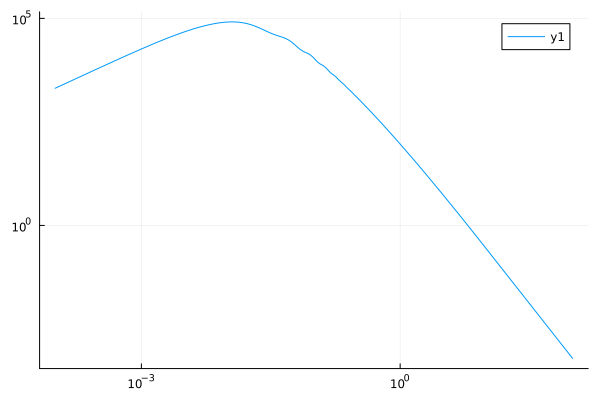

In [135]:
plot(pk_dict["k"], pk_dict["pk_lin"][1,:], xscale=:log10, yscale=:log10)

In [8]:
interp = BSplineInterpolation(W["chi_cl"], W["z_cl"], 3, :ArcLen, :Average, extrapolate=true)
my_chi = interp.(pk_dict["z"]);

In [9]:
itp = interpolate((my_chi, log10.(pk_dict["k"])), log10.(pk_dict["pk_lin"]), Gridded(Linear()))
itp_with_extrapolation = extrapolate(itp, Line());

In [10]:
#Define our grid
kmax = 200/13 
kmin = 2.5/7000
k = LinRange(kmin, kmax, 40000)
nχ = 100
χ = LinRange(26, 7000, nχ)

log_pk_interp = [itp_with_extrapolation(i, j) for i in χ, j in log10.(k)];

In [11]:
function power_spectrum(k, χ1, χ2, interpolator)
    P1 = 10 .^interpolator(χ1, k)
    P2 = 10 .^interpolator(χ2, k)
    
    return @. sqrt(P1 * P2)
end

power_spectrum(k, χ1, χ2) = power_spectrum(k, χ1, χ2, itp_with_extrapolation);

In [12]:
#calculate coefficients of chebychev decomposition
n_cheb = 128
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum(k_cheb,χ[i],χ[j]), log10(kmin), log10(kmax));
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end

# Load brute force intergrals

In [234]:
function load_ws_CC(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "old_tests/symmetry/w_brute_CC/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end

function load_ws_LL(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "old_tests/symmetry/w_brute_LL/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end

function load_ws_CL(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "old_tests/symmetry/w_brute_CL/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end;

In [235]:
w_brute_CC = load_ws_CC(nχ)
w_brute_LL = load_ws_LL(nχ)
w_brute_CL = load_ws_CL(nχ);

# Load local diagonals

In [13]:
function load_loc_CC(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_CC_local/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

function load_loc_CL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_CL_local/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

function load_loc_LL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_LL_local/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [15]:
T_loc_CC = load_loc_CC(nχ, n_cheb)
w_loc_CC = Will.w_ell_tullio(coeff, T_loc_CC)
T_loc_LL = load_loc_LL(nχ, n_cheb)
w_loc_LL = Will.w_ell_tullio(coeff, T_loc_LL)
T_loc_CL = load_loc_CL(nχ, n_cheb)
w_loc_CL = Will.w_ell_tullio(coeff, T_loc_CL);

# Symmetry jobs
Those jobs used 40 cpus (full node) and the lower integration accuracy

## P-adaptive

In [163]:
function load_T_CC(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "old_tests/symmetry/p-adaptive/T_tilde_CC/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [164]:
function load_T_LL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(length(ell_vector), nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "old_tests/symmetry/p-adaptive/T_tilde_LL/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [165]:
function load_T_CL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(length(ell_vector), nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "old_tests/symmetry/p-adaptive/T_tilde_CL/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [166]:
T_CC_symmetry = load_T_CC(nχ, n_cheb)
w_CC_symmetry = Will.w_ell_tullio(coeff, T_CC_symmetry)
T_CL_symmetry = load_T_CL(nχ, n_cheb)
w_CL_symmetry = Will.w_ell_tullio(coeff, T_CL_symmetry)
T_LL_symmetry = load_T_LL(nχ, n_cheb)
w_LL_symmetry = Will.w_ell_tullio(coeff, T_LL_symmetry);

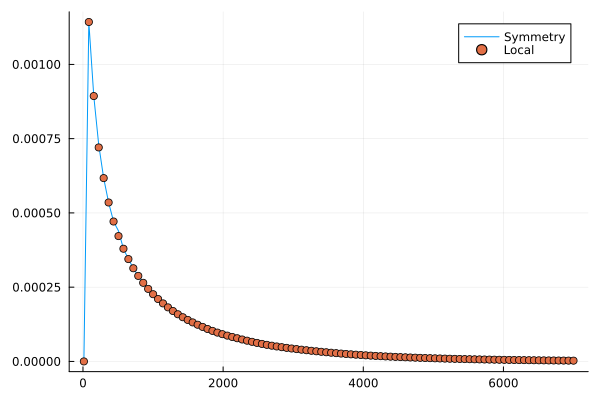

In [20]:
i = 21
plot(χ, diag(w_CC_symmetry[i,:,:]), label="Symmetry")
scatter!(χ, diag(w_loc_CC[i,:,:]), label="Local")

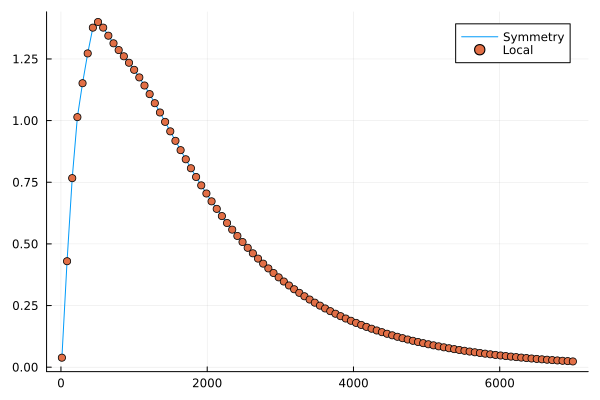

In [21]:
i = 6
plot(χ, diag(w_CL_symmetry[i,:,:]), label="Symmetry")
scatter!(χ, diag(w_loc_CL[i,:,:]), label="Local")

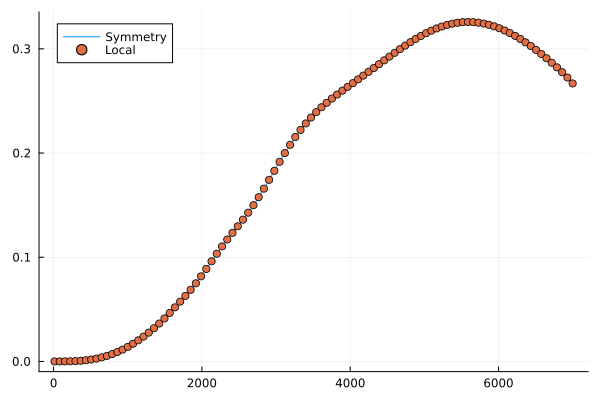

In [22]:
i = 21
plot(χ, diag(w_LL_symmetry[i,:,:]), label="Symmetry")
scatter!(χ, diag(w_loc_LL[i,:,:]), label="Local")

### Comparison symmetry-brute force

#### Clustering-clustering

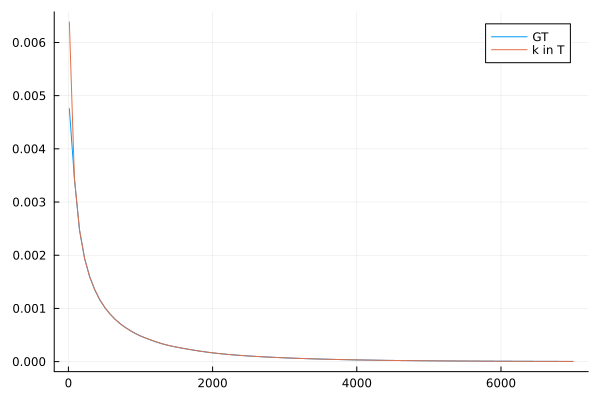

In [170]:
i = 15
plot(χ, diag(w_brute_CC[i,:,:]), label = "GT")
plot!(χ, diag(w_CC_symmetry[i,:,:]), label = "k in T")
#plot!(χ, diag(w_loc_CC[i,:,:]), label="Local")

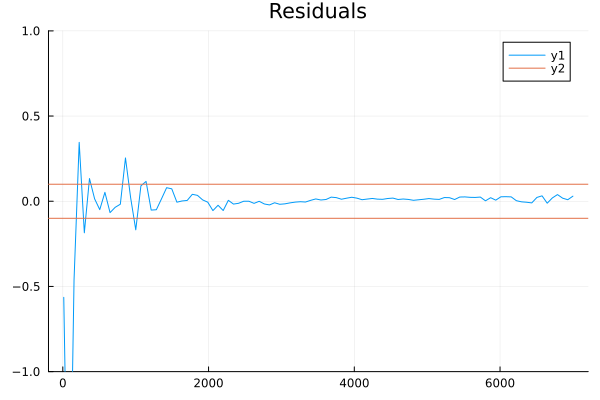

In [247]:
plot(χ, 100*(1 .- diag(w_CC_symmetry[i,:,:]) ./ diag(w_brute_CC[i,:,:])), title = "Residuals", ylim=(-1,1))
hline!([-0.1,0.1])

#### Lensing-lensing

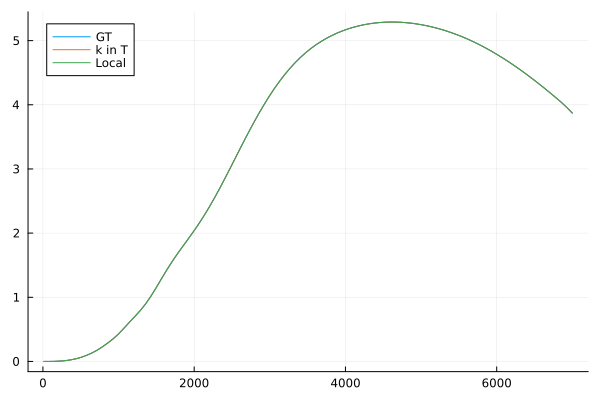

In [106]:
i = 15
plot(χ, diag(w_brute_LL[i,:,:]), label = "GT")
plot!(χ, diag(w_LL_symmetry[i,:,:]), label = "k in T")
plot!(χ, diag(w_loc_LL[i,:,:]), label="Local")

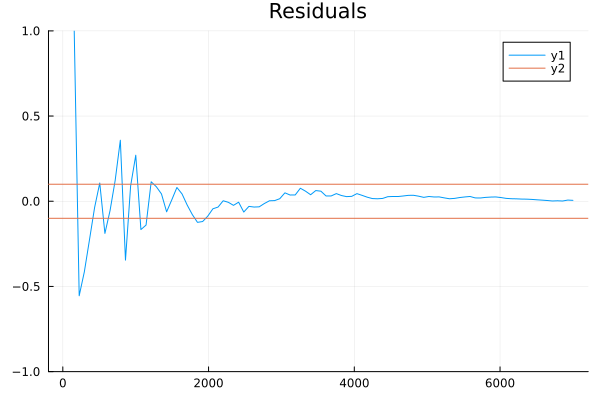

In [112]:
plot(χ, 100*(1 .- diag(w_LL_symmetry[i,:,:]) ./ diag(w_brute_LL[i,:,:])), title = "Residuals", ylim=(-1,1))
hline!([-0.1,0.1])

#### Clustering-lensing

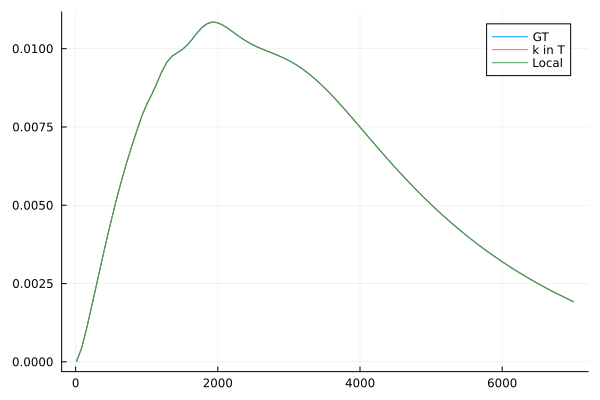

In [109]:
i = 16
plot(χ, diag(w_brute_CL[i,:,:]), label = "GT")
plot!(χ, diag(w_CL_symmetry[i,:,:]), label = "k in T")
plot!(χ, diag(w_loc_CL[i,:,:]), label="Local")

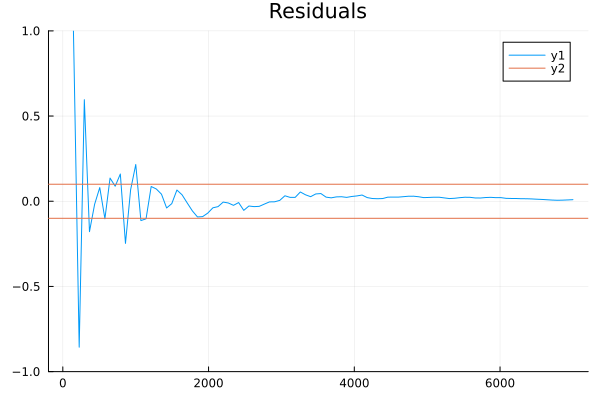

In [113]:
plot(χ, 100*(1 .- diag(w_CL_symmetry[i,:,:]) ./ diag(w_brute_CL[i,:,:])), title = "Residuals", ylim=(-1,1))
hline!([-0.1,0.1])

    Things are good, but the clustering-clustering are not looking so hot and i don't get why.

# New strategy - first attempts

In [43]:
w_cheb = Will.w_ell_tullio(coeff, T);

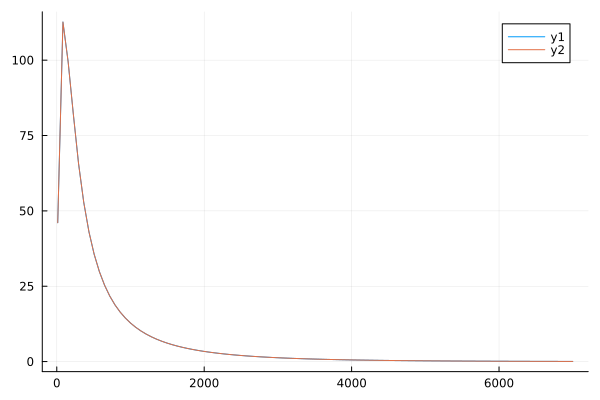

In [46]:
plot(χ, diag(result))
plot!(χ, diag(w_cheb[1,:,:]))

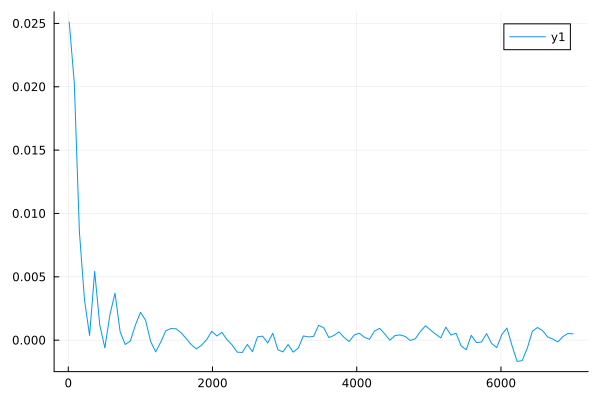

In [47]:
plot(χ, 100 .* (1 .- diag(w_cheb[1,:,:]) ./ diag(result)))

# Full analysis

## Brute force

In [12]:
function load_ws_CC(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "symmetry/w_brute_CC/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end

function load_ws_LL(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "symmetry/w_brute_LL/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end

function load_ws_CL(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "symmetry/w_brute_CL/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end;

In [13]:
w_brute_CC = load_ws_CC(nχ)
w_brute_LL = load_ws_LL(nχ)
w_brute_CL = load_ws_CL(nχ);

## $\tilde T$

In [106]:
function load_T_CC(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "symmetry/T_tilde_CC/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

function load_T_LL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(length(ell_vector), nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "symmetry/T_tilde_LL/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

function load_T_CL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(length(ell_vector), nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "symmetry/T_tilde_CL/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [107]:
T_CC_grid = load_T_CC(nχ, n_cheb)
w_CC_grid = Will.w_ell_tullio(coeff, T_CC_grid)
T_CL_grid = load_T_CL(nχ, n_cheb)
w_CL_grid = Will.w_ell_tullio(coeff, T_CL_grid)
T_LL_grid = load_T_LL(nχ, n_cheb)
w_LL_grid = Will.w_ell_tullio(coeff, T_LL_grid);

## A few plots

### Clustering-clustering

In [128]:
filename = "symmetry/local_test/T_tilde_l_288.3.npy"
T_test = npzread(filename)
w_test =  Will.w_ell_tullio(coeff, T_test);

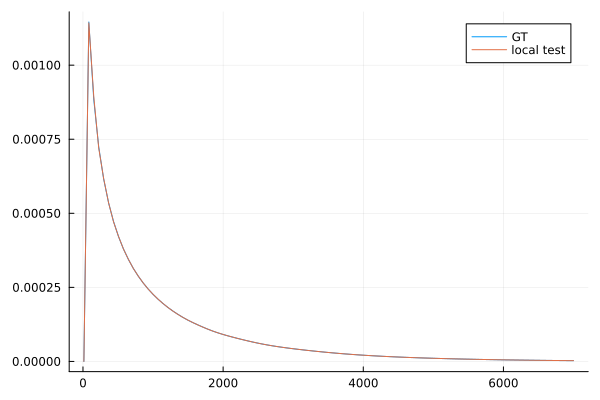

In [132]:
i = 21
plot(χ, diag(w_brute_CC[i,:,:]), label = "GT")
#plot!(χ, diag(w_CC_grid[i,:,:]), label = "k in T")
plot!(χ, diag(w_test[1,:,:]), label = "local test")

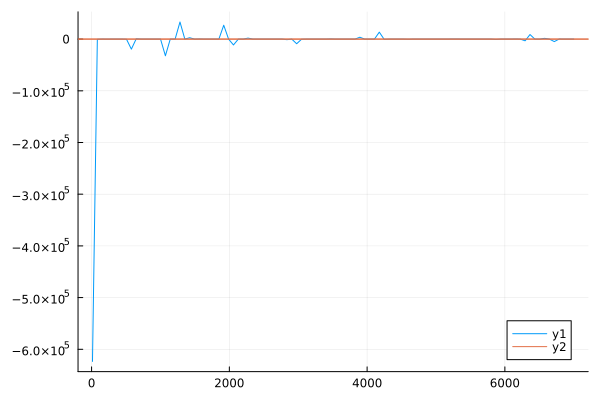

In [111]:
plot(χ, 100 .* (1 .- diag(w_CC_grid[i,:,:]) ./ diag(w_brute_CC[i,:,:])))
hline!([-0.1,0.1])

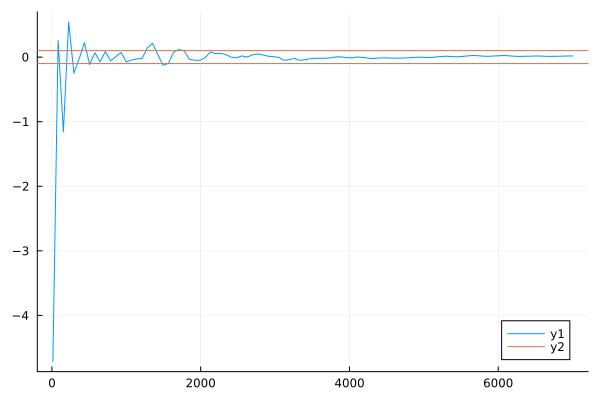

In [131]:
plot(χ, 100 .* (1 .- diag(w_test[1,:,:]) ./ diag(w_brute_CC[i,:,:])))
hline!([-0.1,0.1])

### Lensing-lensing

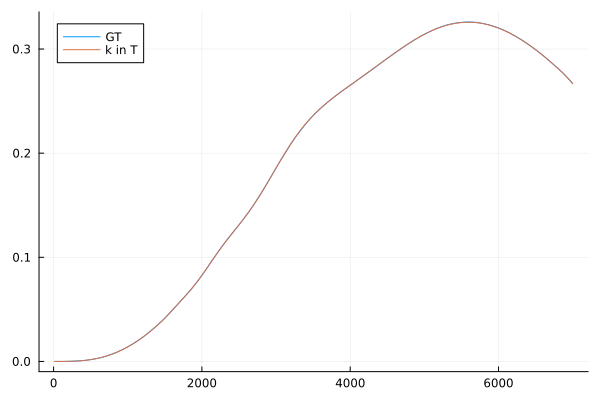

In [31]:
i = 21
plot(χ, diag(w_brute_LL[i,:,:]), label = "GT")
plot!(χ, diag(w_LL_grid[i,:,:]), label = "k in T")

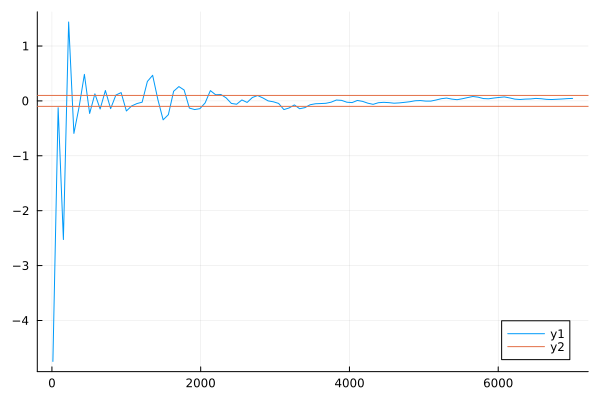

In [32]:
plot(χ, 100 .* (1 .- diag(w_LL_grid[i,:,:]) ./ diag(w_brute_LL[i,:,:])))
hline!([-0.1,0.1])

### Clustering-lensing

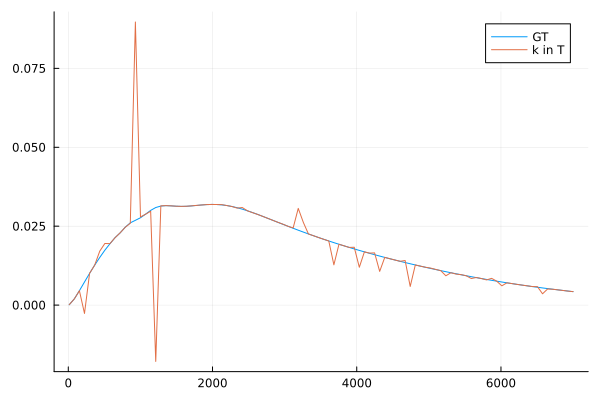

In [126]:
i = 13
plot(χ, diag(w_brute_CL[i,:,:]), label = "GT")
plot!(χ, diag(w_CL_grid[i,:,:]), label = "k in T")

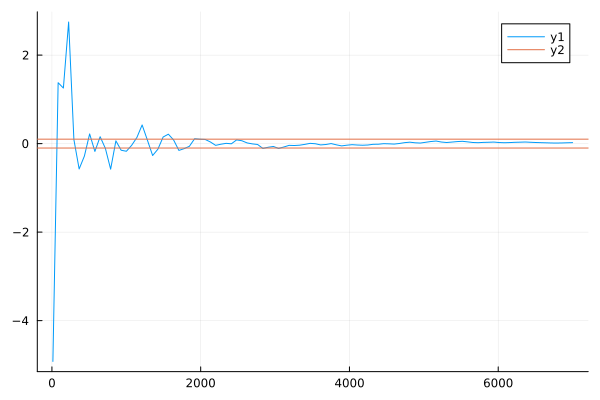

In [55]:
plot(χ, 100 .* (1 .- diag(w_CL_grid[i,:,:]) ./ diag(w_brute_CL[i,:,:])))
hline!([-0.1,0.1])

In [140]:
l2_bessel_1 = npzread("symmetry/debug/bessel_l_2.0_i_1.npy")
l2_bessel_50 = npzread("symmetry/debug/bessel_l_2.0_i_50.npy")
l2_bessel_100 = npzread("symmetry/debug/bessel_l_2.0_i_100.npy");
l288_bessel_1 = npzread("symmetry/debug/bessel_l_288.3_i_1.npy")
l288_bessel_50 = npzread("symmetry/debug/bessel_l_288.3_i_50.npy")
l288_bessel_100 = npzread("symmetry/debug/bessel_l_288.3_i_100.npy");

In [143]:
sum(l288_bessel_1-l288_bessel_50)

0.0

In [144]:
l2_cheb_1 = npzread("symmetry/debug/chebpoly_l_2.0_i_1.npy")
l2_cheb_50 = npzread("symmetry/debug/chebpoly_l_2.0_i_50.npy")
l2_cheb_100 = npzread("symmetry/debug/chebpoly_l_2.0_i_100.npy");
l288_cheb_1 = npzread("symmetry/debug/chebpoly_l_288.3_i_1.npy")
l288_cheb_50 = npzread("symmetry/debug/chebpoly_l_288.3_i_50.npy")
l288_cheb_100 = npzread("symmetry/debug/chebpoly_l_288.3_i_100.npy");

In [149]:
sum(l288_cheb_100-l288_cheb_50)

0.0

In [151]:
T_2_debug = npzread("symmetry/debug/T_tilde_l_2.0.npy")
T_288_debug = npzread("symmetry/debug/T_tilde_l_288.3.npy");

In [152]:
w_2_deb = Will.w_ell_tullio(coeff, T_2_debug)
w_288_deb = Will.w_ell_tullio(coeff, T_288_debug);

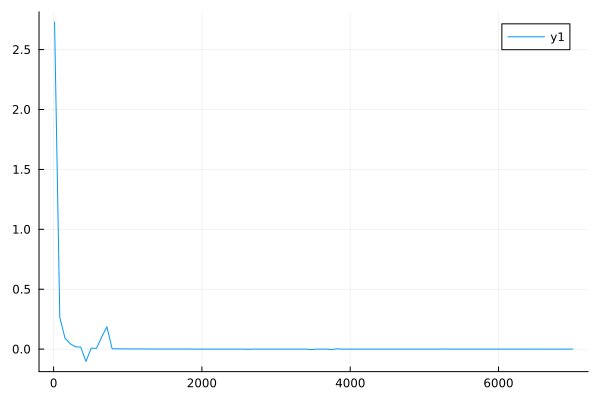

In [154]:
plot(χ, diag(w_2_deb[1,:,:]))

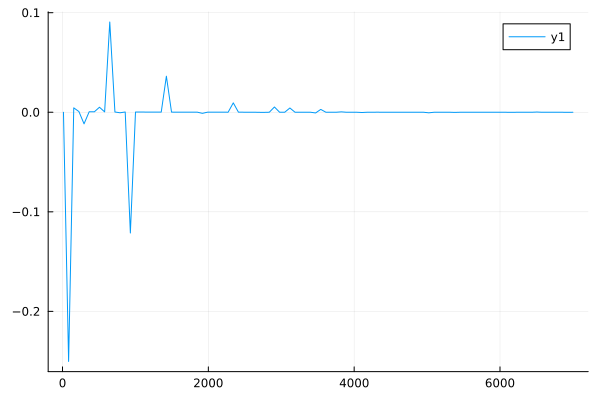

In [155]:
plot(χ, diag(w_288_deb[1,:,:]))

# Testing a possible solution: @tturbo

### let's write it better 

In [14]:
function w_brute_ttuturbo_better(f, ℓ, χ, kmin, kmax)
    N = 2^(16)+1
    nχ = length(χ)
    CC_obj = FastTransforms.chebyshevmoments1(Float64, N)
    w = FastTransforms.clenshawcurtisweights(CC_obj)
    x = FastTransforms.clenshawcurtisnodes(Float64, N)
    
    x = (kmax - kmin) / 2 * x .+ (kmin + kmax) / 2 #rescale them on the appropriate interval
    w = (kmax - kmin) / 2 * w

    f_bessel = zeros(nχ, length(x))
    Threads.@threads for i in 1:nχ
        f_bessel[i,:] = @views Bessels.sphericalbesselj.(ℓ, χ[i] * x)
    end

    result = zeros(nχ, nχ)
    pk_grid = zeros(nχ, nχ, length(x))
    @time for i in 1:nχ
        for j in i:nχ
            for k in 1:length(x)
                pk_grid[i,j,k] = power_spectrum(log10(x[k]), χ[i], χ[j]) 
                pk_grid[j,i,k] = pk_grid[i,j,k]
            end
        end
    end
    # perchè assegnare benchmark_f nel loop dopo rompe loopvectorization?
    @tturbo for i ∈ axes(pk_grid,1), j ∈ axes(pk_grid,2)
        Cij = zero(etype(w))
        for k ∈ axes(w,1)
            Cij +=  pk_grid[i,j,k] * f_bessel[i,k] * f_bessel[j,k] * (x[k] ^ 2) * w[k]
        end
        result[i,j] = Cij
        #result[j,i] = result[i,j] 
    end
    return result
end;

In [15]:
nχ = 100
χ = LinRange(13, 7000, nχ) 
ℓ = 2.0
@time w_brute = w_brute_ttuturbo_better(power_spectrum, ℓ, χ, kmin, kmax);

165.808303 seconds (3.97 G allocations: 64.040 GiB, 1.05% gc time, 0.03% compilation time)
170.746973 seconds (3.97 G allocations: 70.044 GiB, 1.09% gc time, 2.10% compilation time)


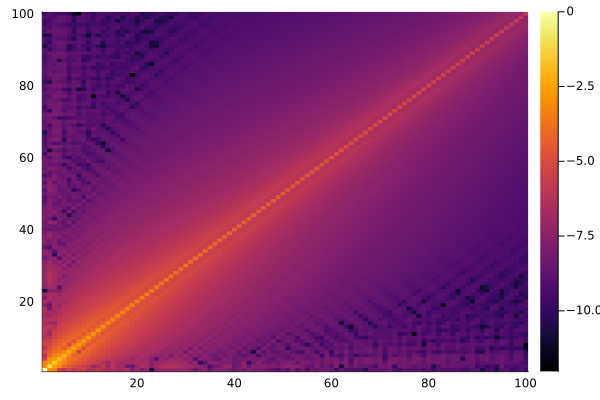

In [16]:
heatmap(log10.(abs.(w_brute/maximum(w_brute))))

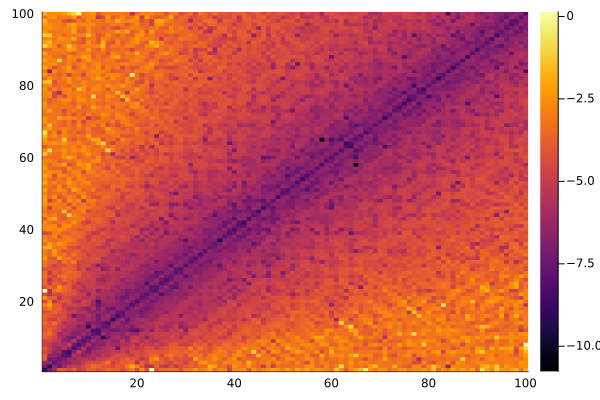

In [17]:
heatmap(log10.(abs.(1 .- (w_brute ./w_brute_CC[1,:,:]))))

### Now let's go from f to T_tilde

function turbo_T̃(f, ℓ, χ, kmin, kmax)
    N = 2^(20)+1
    nχ = length(χ)
    CC_obj = FastTransforms.chebyshevmoments1(Float64, N)
    w = FastTransforms.clenshawcurtisweights(CC_obj)
    x = FastTransforms.clenshawcurtisnodes(Float64, N)
    
    #rescaling to my interval
    x = (kmax - kmin) / 2 * x .+ (kmin + kmax) / 2 
    w = (kmax - kmin) / 2 * w

    n_cheb = 128
    k_cheb = chebpoints(n_cheb, log10(minimum(minimum.(x))), log10(maximum(maximum.(x))))
    c = chebinterp(f(k_cheb,χ[1],χ[1]), log10(minimum(minimum.(x))), log10(maximum(maximum.(x))))

    f_bessel = zeros(length(χ), length(x))
    Threads.@threads for i in 1:length(χ)
        f_bessel[i,:] = @views Bessels.sphericalbesselj.(ℓ, χ[i] * x)
    end


    T = zeros(n_cheb,length(x))
    for i in 1:n_cheb
        copy_c = deepcopy(c) #copio l'interpolante 
        copy_c.coefs .*= 0 #azzero i coeff del polinomio
        copy_c.coefs[i] = 1.
        T[i,:] = copy_c.(log10.(x))
    end
    

    T_tilde = zeros(1, nχ, nχ, n_cheb+1)
    @tturbo for l in 1:n_cheb+1, i in 1:nχ, j in 1:nχ
        Cij = zero(etype(w))
        for k in 1:length(x)
            Cij +=  T[l,k] * f_bessel[i,k] * f_bessel[j,k] * (x[k] ^ 2) * w[k]
        end
        T_tilde[1,i,j,l] = Cij
    end         
    return T_tilde
end

In [33]:
nχ = 100
χ = LinRange(13, 7000, nχ) 
ℓ = 2.0
@time T = turbo_T̃(power_spectrum, ℓ, χ, kmin, kmax);

304.754263 seconds (106.70 k allocations: 4.431 GiB, 0.06% gc time, 0.06% compilation time)


In [34]:
w_cheb = Will.w_ell_tullio(coeff, T);

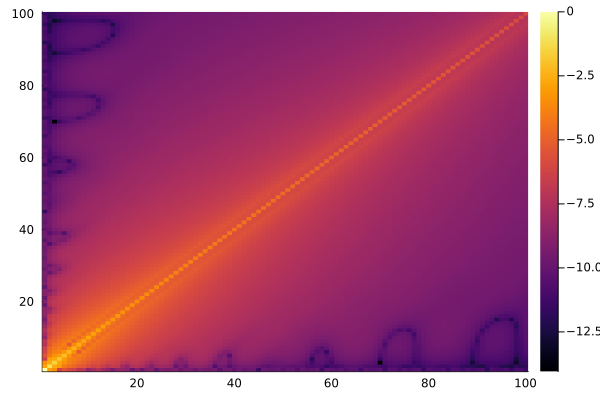

In [35]:
heatmap(log10.(abs.(w_cheb[1,:,:]/maximum(w_cheb))))

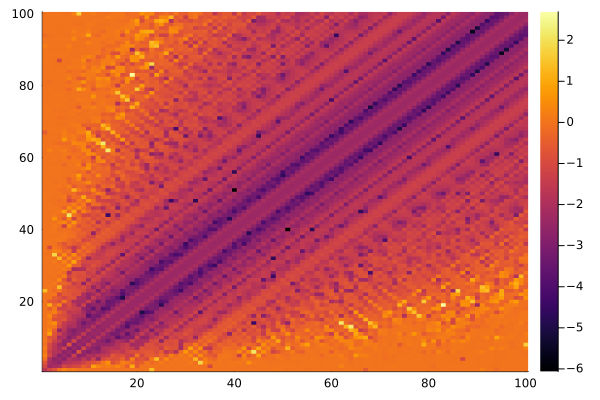

In [36]:
heatmap(log10.(abs.(1 .- (w_cheb[1,:,:] ./w_brute_CC[1,:,:]))))

# Load w brute force

In [13]:
function load_ws_CC(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "w_brute_CC/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end

function load_ws_LL(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "w_brute_LL/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end

function load_ws_CL(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "w_brute_CL/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end;

In [14]:
w_brute_CC = load_ws_CC(nχ)
w_brute_LL = load_ws_LL(nχ)
w_brute_CL = load_ws_CL(nχ);

# New implementation: results

In [15]:
function load_T_CC(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_CC/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

function load_T_CL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_CL/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

function load_T_LL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_LL/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [16]:
T_CC = load_T_CC(nχ, n_cheb)
w_CC = Will.w_ell_tullio(coeff, T_CC)
T_CL = load_T_CL(nχ, n_cheb)
w_CL = Will.w_ell_tullio(coeff, T_CL)
T_LL = load_T_LL(nχ, n_cheb)
w_LL = Will.w_ell_tullio(coeff, T_LL);

## CC

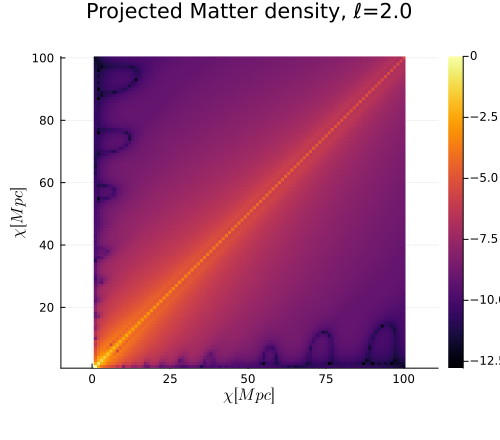

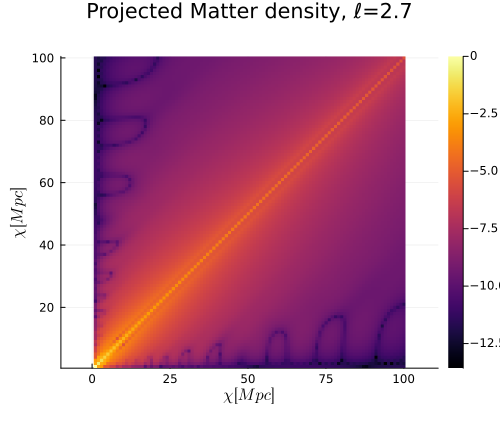

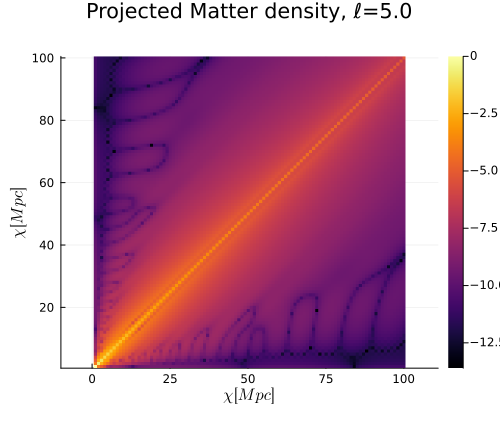

In [17]:
plots = []
for i in 1:3
    push!(plots, plot_pmd(w_CC, i))
end

for plot in plots
    display(plot)
end

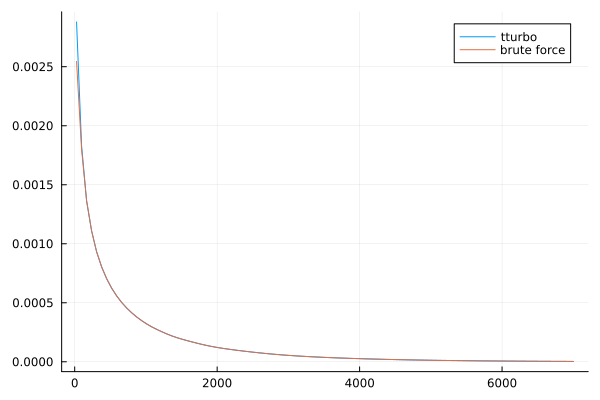

In [18]:
i = 18
plot(χ, diag(w_CC[i,:,:]), label="tturbo")
plot!(χ, diag(w_brute_CC[i,:,:]), label="brute force")

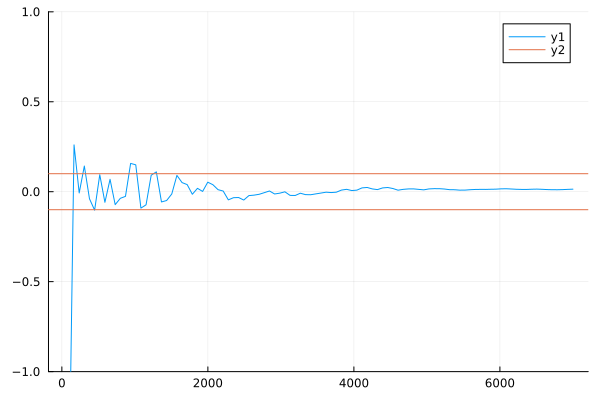

In [19]:
plot(χ, 100*(1 .- diag(w_CC[i,:,:])./diag(w_brute_CC[i,:,:])), ylim=(-1,1))
hline!([-0.1,0.1])

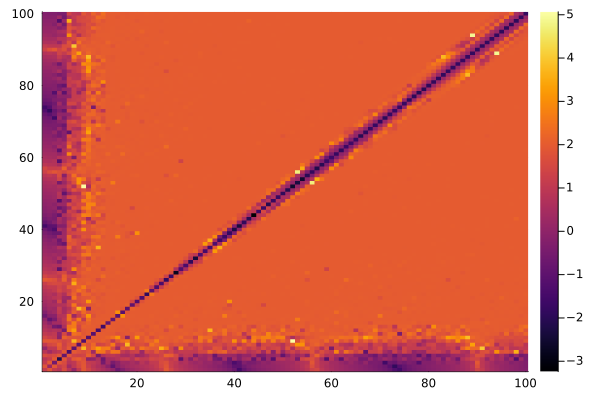

In [20]:
heatmap(log10.(abs.(100*(1 .- (w_CC[i,:,:] ./ w_brute_CC[i,:,:])))))

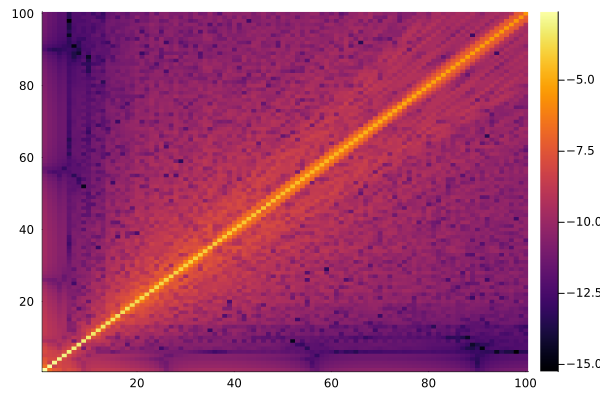

In [21]:
heatmap(log10.(abs.(w_brute_CC[i,:,:])))

[ Info: Saved animation to /Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/anim_CC.gif


Plots.AnimatedGif("/Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/anim_CC.gif")
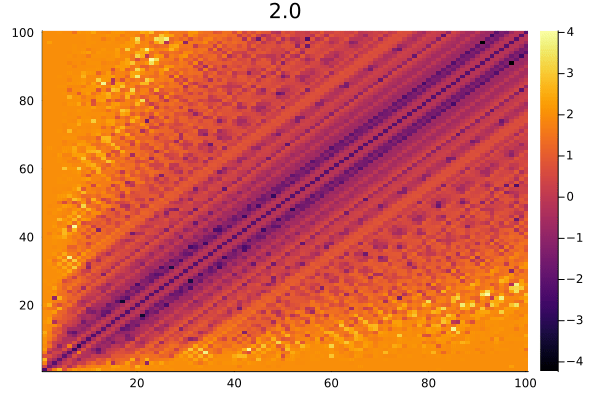

In [22]:
anim = @animate for i ∈ 1:21
    heatmap(log10.(abs.(100*(1 .- (w_CC[i,:,:] ./ w_brute_CC[i,:,:])))), title = npzread("ell_vector.npy")[i])
end
gif(anim, "anim_CC.gif", fps = 3)


## CL

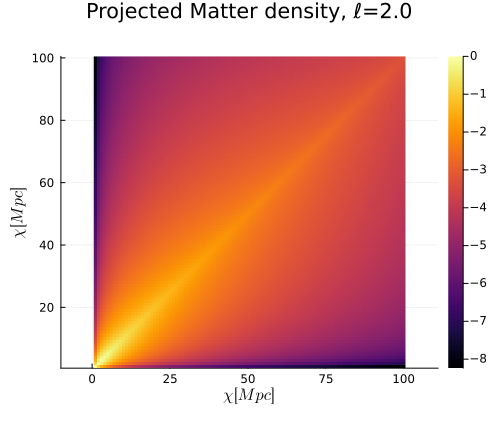

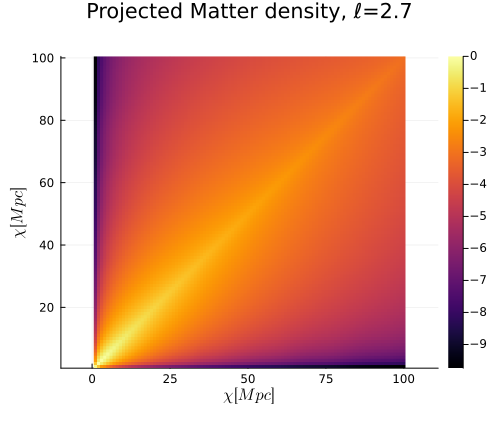

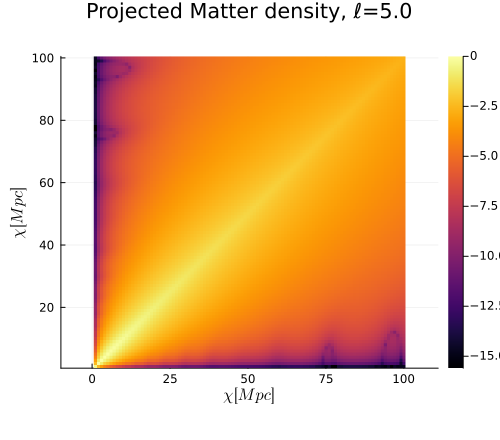

In [23]:
plots = []
for i in 1:3
    push!(plots, plot_pmd(w_CL, i))
end

for plot in plots
    display(plot)
end

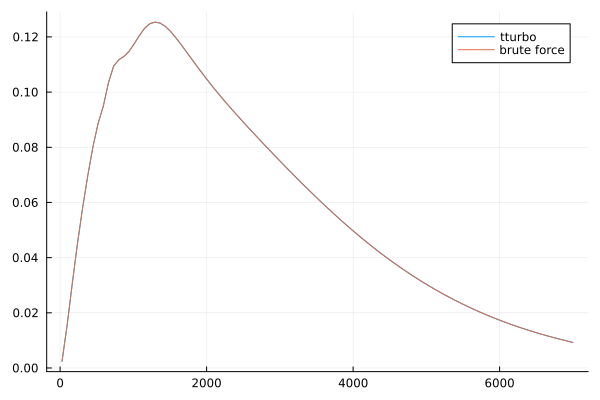

In [24]:
i = 10
plot(χ, diag(w_CL[i,:,:]), label="tturbo")
plot!(χ, diag(w_brute_CL[i,:,:]), label="brute force")

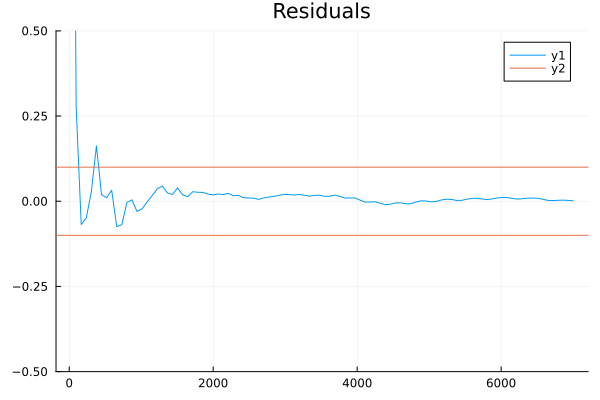

In [25]:
plot(χ, 100*(1 .- diag(w_CL[i,:,:]) ./ diag(w_brute_CL[i,:,:])), title = "Residuals", ylim=(-0.5,0.5))
hline!([-0.1,0.1])

[ Info: Saved animation to /Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/anim_CL.gif


Plots.AnimatedGif("/Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/anim_CL.gif")
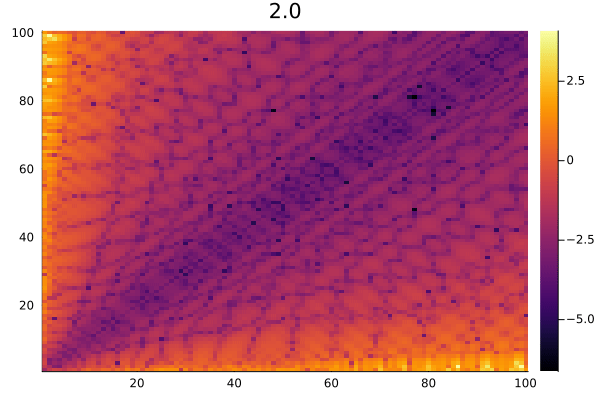

In [26]:
anim = @animate for i ∈ 1:21
    heatmap(log10.(abs.(100*(1 .- (w_CL[i,:,:] ./ w_brute_CL[i,:,:])))), title = npzread("ell_vector.npy")[i])
end
gif(anim, "anim_CL.gif", fps = 3)

## LL

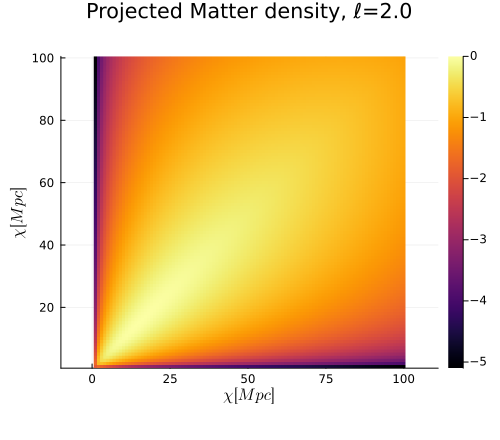

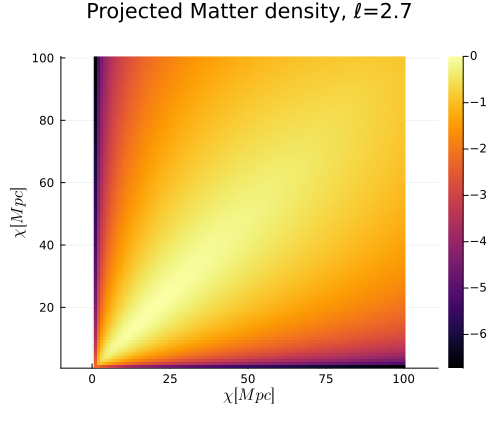

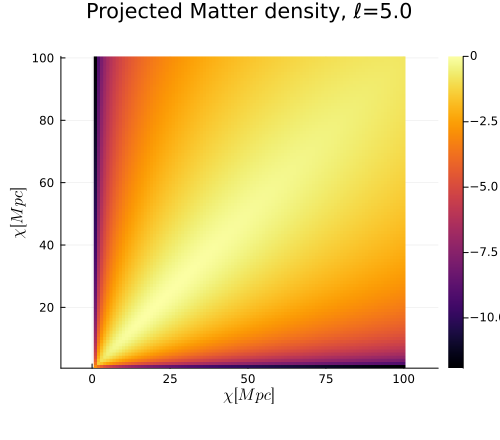

In [27]:
plots = []
for i in 1:3
    push!(plots, plot_pmd(w_LL, i))
end

for plot in plots
    display(plot)
end

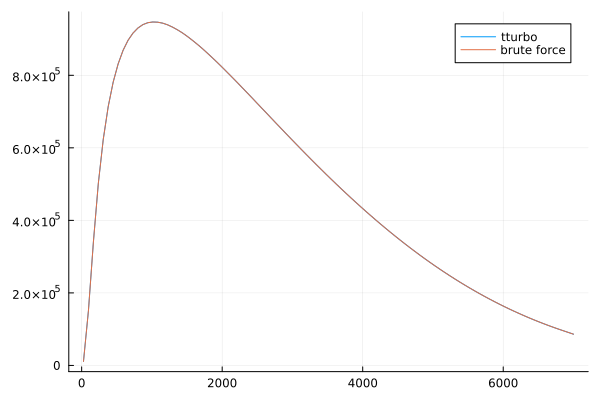

In [28]:
i = 1
plot(χ, diag(w_LL[i,:,:]), label="tturbo")
plot!(χ, diag(w_brute_LL[i,:,:]), label="brute force")

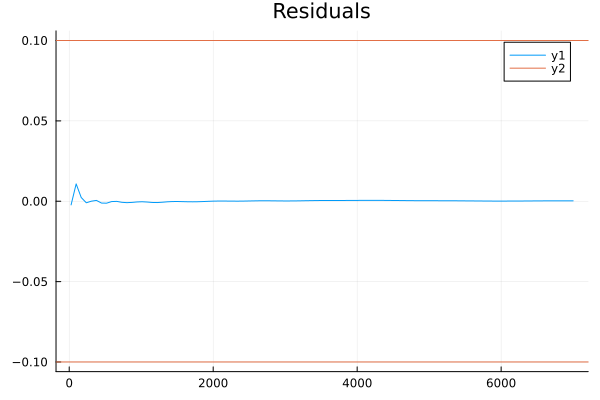

In [29]:
plot(χ, 100*(1 .- diag(w_LL[i,:,:]) ./ diag(w_brute_LL[i,:,:])), title = "Residuals")
hline!([-0.1,0.1])

[ Info: Saved animation to /Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/anim_LL.gif


Plots.AnimatedGif("/Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/anim_LL.gif")
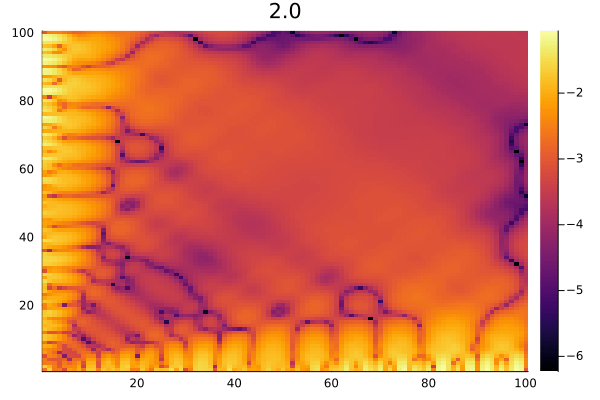

In [30]:
anim = @animate for i ∈ 1:21
    heatmap(log10.(abs.(100*(1 .- (w_LL[i,:,:] ./ w_brute_LL[i,:,:])))), title = npzread("ell_vector.npy")[i])
end
gif(anim, "anim_LL.gif", fps = 3)

# TwoFAST-let's validate the projected matter densities

In [108]:
using TwoFAST
using Dierckx
using DelimitedFiles

In [109]:
#loading test power spectrum
d = readdlm("planck_base_plikHM_TTTEEE_lowTEB_lensing_post_BAO_H070p6_JLA_matterpower.dat", comments=true)
pk = Spline1D(log10.(d[:,1]), d[:,2])

Spline1D(knots=[-5.46028,-5.43133 … 2.98675,3.00847] (986 elements), k=3, extrapolation="nearest", residual=0.0)

In [110]:
#calculate coefficients of chebychev decomposition
n_cheb = 128
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(pk.(k_cheb), log10(kmin), log10(kmax));
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end

In [111]:
w = Will.w_ell_tullio(coeff, T_CC);

In [118]:
N = 4096
chi0 = 0.001
kmin = 1e-5
kmax = 1e3
q = 1.1
ell = [2] 
RR = [1.0]

# calculate M_ll at high ell, result gets saved to a file:
f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
write("out/F21EllCache", f21cache)

# calculate all M_ll, result gets saved to a file:
mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
write("out/MlCache", mlcache)

# calculate wljj:
w00 = Array{Float64}(undef, N, length(RR))
w02 = Array{Float64}(undef, N, length(RR))
w22 = Array{Float64}(undef, N, length(RR))
function outfunc(wjj, ell, rr, RR)
    w00[:,:] = wjj[1]
    #w02[:,:] = wjj[2]
    #w22[:,:] = wjj[3]
end
rr = calcwljj(pk, RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin");

  q=1.1, R=1.0:	  0.004267 seconds (8.20 k allocations: 576.281 KiB)

ℓ = 2
Δℓ = 4
ΔℓRg1 = -4
N = 4096
q = 1.1
kmin = 1.0e-5
kmax = 1000.0
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1000.0
dlrec    = 4
dlrecRg1 = -4
Output size: 131136 bytes = 0.0001221299171447754 GiB
Output size: 131136 bytes = 0.0001221299171447754 GiB
Reading 'out/F21EllCache'...   0.008308 seconds (180 allocations: 132.078 KiB)
ellmax: 4
lmaxcache: 2
fell[:,1,1] = ComplexF64[3.9037178594416995e6 - 9.56135116267927e-10im, 0.0 + 0.0im]
ell 4, elapsed: 7.796287536621094e-5
ell 3, elapsed: 0.00042510032653808594
ell 2, elapsed: 0.00017881393432617188
ell 1, elapsed: 0.0006978511810302734
ell 0, elapsed: 0.0006999969482421875
  0.003569 seconds (339 allocations: 18.000 KiB)
elapsed: 0.0010180473327636719
step:          0.000259 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      4.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000104 sec (0 allocations: 0 byte, 0.0% 

In [119]:
w00

4096×1 Matrix{Float64}:
 0.2782088137372758
 0.2764799176309567
 0.27477957546084514
 0.27310774868572835
 0.27146440252364334
 0.26984950596741536
 0.26826303179930644
 0.2667049566069038
 0.26517526079894854
 0.26367392862190964
 0.26220094817656103
 0.26075631143548667
 0.25934001426048403
 ⋮
 4.773728021270146e-10
 4.74082722817318e-10
 4.708390885932816e-10
 4.676417684563643e-10
 4.644906371364871e-10
 4.613855751078275e-10
 4.5832646860510915e-10
 4.5531320964041547e-10
 4.52345696020274e-10
 4.494238313646849e-10
 4.465475251247962e-10
 4.4371669260356047e-10

In [120]:
#interp = BSplineInterpolation( w00[:,1], rr,  3, :ArcLen, :Average, extrapolate=true)
interp= Spline1D(rr, w00[:,1])
w00_interp = interp.(LinRange(26, 7000, 100))

100-element Vector{Float64}:
 0.004767284080267578
 0.0004140521460641157
 0.00014042337074442142
 6.975615106718208e-5
 4.1562707799404386e-5
 2.75518518139402e-5
 1.9591885314102413e-5
 1.4641446867042689e-5
 1.1354798099034018e-5
 9.062129700547874e-6
 7.3996327380813976e-6
 6.155889565555161e-6
 5.2012352490803366e-6
 ⋮
 1.0195720016211284e-7
 9.968828685754761e-8
 9.74942762438063e-8
 9.537190731572951e-8
 9.331809453850953e-8
 9.132991680272018e-8
 8.940460687087078e-8
 8.7539541851588e-8
 8.573223424017417e-8
 8.398032356287402e-8
 8.228156873845857e-8
 8.063384088968237e-8

In [122]:
function quadosc_cc_valid(ℓ, χ)
    a, E = quadosc(x->pk(log10(x))*Bessels.sphericalbesselj(ℓ, χ*x)^2 * (x^2), kmin, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    b, Eb = quadosc(x->pk(log10(x))*Bessels.sphericalbesselj(ℓ, χ*x)^2 * (x^2), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    return a-b
end;

In [123]:
χ = LinRange(26, 7000, 10)
qosc_test = zeros(10)
println("Let's see what happens")
for (cidx, c) in enumerate(χ)
    println("Processing χ = $c");flush(stdout)
    qosc_test[cidx] = quadosc_cc_valid(2, c)
end

Let's see what happens
Processing χ = 26.0


LoadError: InterruptException:

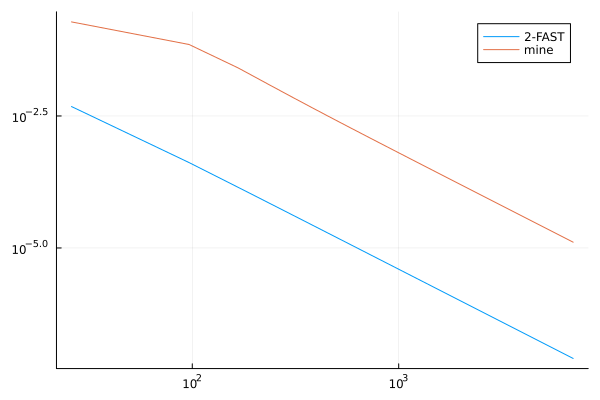

In [121]:
plot(LinRange(26, 7000, 100) ,w00_interp, label="2-FAST", xscale=:log10, yscale=:log10)
plot!(LinRange(26, 7000, 100), diag(w[1,:,:]), label ="mine")
#scatter!(LinRange(26, 7000, 10), qosc_test, label="quadosc")

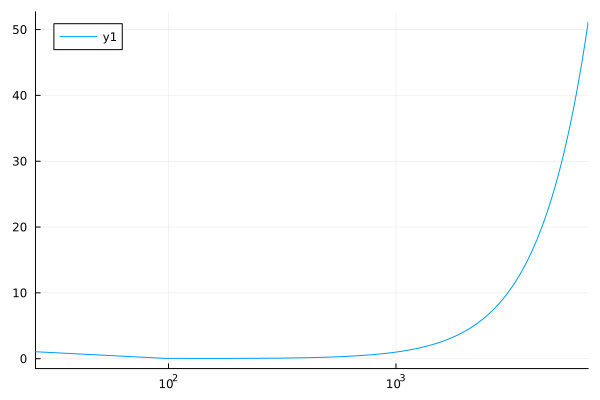

In [70]:
plot(LinRange(26, 7000, 100), (w00_interp ./ diag(w[1,:,:])), xlim=(26,7000), xscale=:log10)

# QuadOSC

In [39]:
using QuadOsc
using FunctionZeros

In [160]:
function quadosc_ll(ℓ, χ)
    a, E = quadosc(x->power_spectrum(log10.(x), χ, χ)*SpecialFunctions.sphericalbesselj(ℓ, χ*x)^2 /(x^2), kmin, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    b, Eb = quadosc(x->power_spectrum(log10.(x), χ, χ)*SpecialFunctions.sphericalbesselj.(ℓ, χ*x)^2 /(x^2), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    return a-b
end;

In [161]:
χ = LinRange(26, 7000, 10)
ℓ = npzread("ell_vector.npy")[1]
#results_ll_bis = zeros(length(ℓ), length(χ))
@time for (lidx,l) in enumerate(ℓ)
    println("Processing ℓ = $l")
    results_ll = zeros(length(χ))
    for (cidx, c) in enumerate(χ)
        println("\tProcessing χ = $c")
        results_ll[cidx] = quadosc_ll(l, c)
        #results_ll_bis[1, cidx ], _ = Cubature.pquadrature(x->power_spectrum(, c, c)*Bessels.sphericalbesselj(2, c*x)^2 /(x^2), kmin, kmax; reltol = 1e-10)
    end
    l_string = string(round(l; digits=1))
    npzwrite("quadosc_LL/w_l_$l_string.npy", results_ll)
end

Processing ℓ = 2.0
	Processing χ = 26.0
	Processing χ = 800.8888888888888
	Processing χ = 1575.7777777777776
	Processing χ = 2350.6666666666665
	Processing χ = 3125.555555555555
	Processing χ = 3900.444444444445
	Processing χ = 4675.333333333333
	Processing χ = 5450.222222222222
	Processing χ = 6225.11111111111
	Processing χ = 7000.0
275.168771 seconds (148.19 M allocations: 1.128 TiB, 24.42% gc time, 0.25% compilation time)


In [178]:
npzread("quadosc_LL/w_l_2.0.npy")

10-element Vector{Float64}:
 1.0336980151430711e-7
 0.012232075575287903
 0.07693619611795736
 0.18465662459721677
 0.31742776000608813
 0.3998531107458267
 0.4773727020490797
 0.505703051593676
 0.4686715164231109
 0.3919386060205138

In [41]:
function quadosc_cl(ℓ, χ)
    a, E = quadosc(x->power_spectrum(log10(x), χ, χ)*Bessels.sphericalbesselj(ℓ, χ*x)^2 , kmin, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    b, Eb = quadosc(x->power_spectrum(log10(x), χ, χ)*Bessels.sphericalbesselj(ℓ, χ*x)^2, kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    return a-b
end;

In [108]:
χ = LinRange(26, 7000, 10)
ℓ = npzread("ell_vector.npy")[21]
@time for (lidx,l) in enumerate(ℓ)
    println("Processing ℓ = $l")
    results_cl = zeros(length(χ))
    for (cidx, c) in enumerate(χ)
        println("\tProcessing χ = $c")
        results_cl[cidx] = quadosc_cl(l, c)
    end
    l_string = string(round(l; digits=1))
    npzwrite("quadosc_CL/w_l_$l_string.npy", results_cl)
end

Processing ℓ = 288.28352543195393
	Processing χ = 26.0
	Processing χ = 800.8888888888888
	Processing χ = 1575.7777777777776
	Processing χ = 2350.6666666666665
	Processing χ = 3125.555555555555
	Processing χ = 3900.444444444445
	Processing χ = 4675.333333333333
	Processing χ = 5450.222222222222
	Processing χ = 6225.11111111111
	Processing χ = 7000.0
369.432321 seconds (193.73 M allocations: 1.874 TiB, 20.86% gc time, 0.01% compilation time)


In [179]:
function quadosc_cc(ℓ, χ)
    a, E = quadosc(x->power_spectrum(log10(x), χ, χ)*Bessels.sphericalbesselj(ℓ, χ*x)^2 * (x^2), kmin, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    b, Eb = quadosc(x->power_spectrum(log10(x), χ, χ)*Bessels.sphericalbesselj(ℓ, χ*x)^2 * (x^2), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    return a-b
end;

In [ ]:
χ = LinRange(26, 7000, 10)
ℓ = npzread("ell_vector.npy")[20]
@time for (lidx,l) in enumerate(ℓ)
    println("Processing ℓ = $l")
    results_cc = zeros(length(χ))
    for (cidx, c) in enumerate(χ)
        println("\tProcessing χ = $c")
        results_cc[cidx] = quadosc_cc(l, c)
    end
    l_string = string(round(l; digits=1))
    npzwrite("quadosc_CC/w_l_$l_string.npy", results_cc)
end

## Plots

### LL

In [162]:
function load_quadosc_LL(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_qosc = zeros(length(ell_vector), nχ)
    for i in 1:19
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "quadosc_LL/w_l_$l_string.npy"
        full_qosc[i,:] = npzread(filename)
    end
    return full_qosc
end

load_quadosc_LL (generic function with 2 methods)

In [163]:
results_ll = load_quadosc_LL(10);

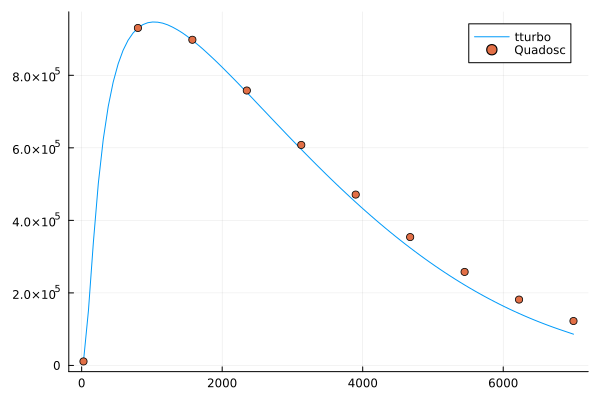

In [164]:
i = 1
plot(LinRange(26, 7000, 100), diag(w_LL[i,:,:]), label="tturbo")
scatter!(LinRange(26, 7000, 10), results_ll[i,:], label="Quadosc")

[ Info: Saved animation to /Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/comparison_ll.gif


Plots.AnimatedGif("/Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/comparison_ll.gif")
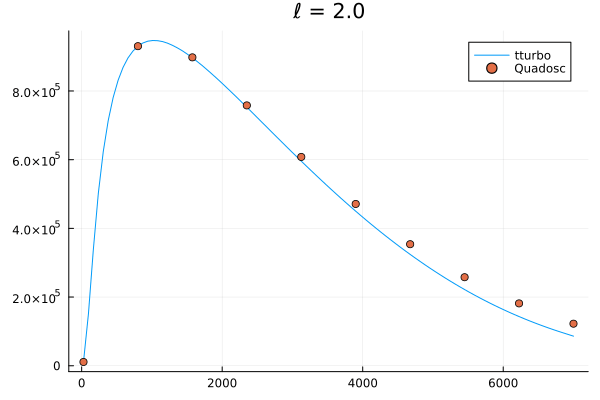

In [154]:
anim = @animate for i ∈ 1:19
    plot(LinRange(26, 7000, 100), diag(w_LL[i,:,:]), label="tturbo", title = "ℓ = $(npzread("ell_vector.npy")[i])")
    scatter!(LinRange(26, 7000, 10), results_ll[i,:], label="Quadosc")
end
gif(anim, "comparison_ll.gif" ,fps = 1)

In [137]:
 diag(w_LL[1,:,:])[100]

86198.11392758145

### CL 

In [190]:
function load_quadosc_CL(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_qosc = zeros(length(ell_vector), nχ)
    for i in 1:19
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "quadosc_CL/w_l_$l_string.npy"
        full_qosc[i,:] = npzread(filename)
    end
    return full_qosc
end

load_quadosc_CL (generic function with 2 methods)

In [191]:
results_cl = load_quadosc_CL(10);

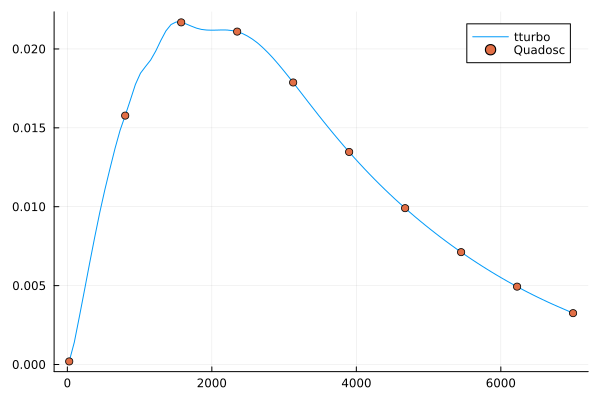

In [192]:
i = 14
plot(LinRange(26, 7000, 100), diag(w_CL[i,:,:]), label="tturbo")
scatter!(LinRange(26, 7000, 10), results_cl[i,:], label="Quadosc")

[ Info: Saved animation to /Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/comparison_cl.gif


Plots.AnimatedGif("/Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/comparison_cl.gif")
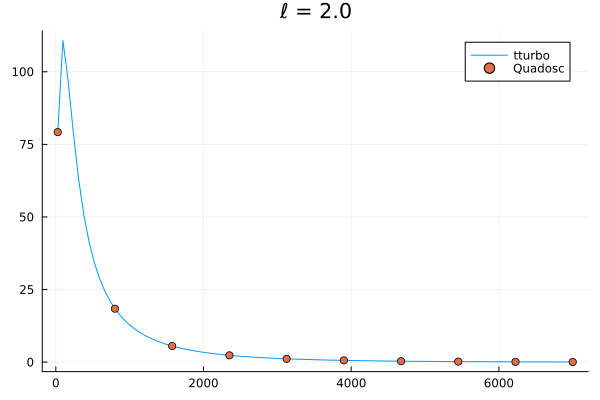

In [208]:
anim = @animate for i ∈ 1:19
    plot(LinRange(26, 7000, 100), diag(w_CL[i,:,:]), label="tturbo", title = "ℓ = $(npzread("ell_vector.npy")[i])")
    scatter!(LinRange(26, 7000, 10), results_cl[i,:], label="Quadosc")
end
gif(anim, "comparison_cl.gif" ,fps = 1)

### CC

In [203]:
function load_quadosc_CC(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_qosc = zeros(length(ell_vector), nχ)
    for i in 1:19
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "quadosc_CC/w_l_$l_string.npy"
        full_qosc[i,:] = npzread(filename)
    end
    return full_qosc
end

load_quadosc_CC (generic function with 2 methods)

In [204]:
results_cc = load_quadosc_CC(10);

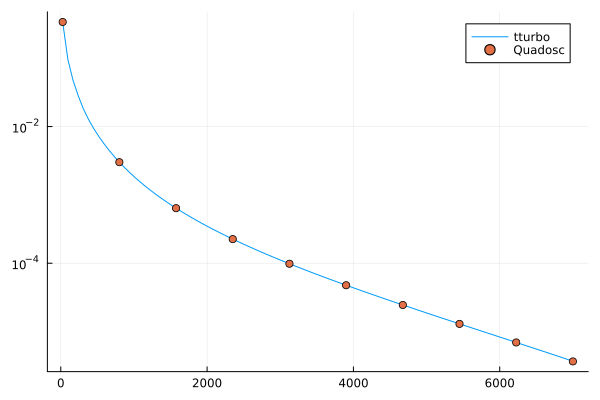

In [205]:
i = 4
plot(LinRange(26, 7000, 100), diag(w_CC[i,:,:]), label="tturbo", yscale=:log10)
scatter!(LinRange(26, 7000, 10), results_cc[i,:], label="Quadosc")

[ Info: Saved animation to /Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/comparison_cc.gif


Plots.AnimatedGif("/Users/sofiachiarenza/Desktop/PhD_Stuff/cheb_bessel_tests-main/comparison_cc.gif")
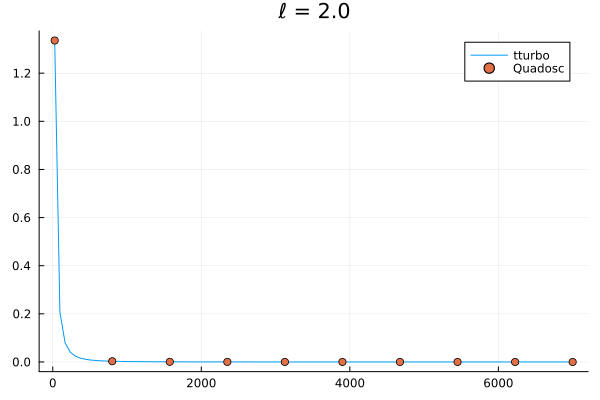

In [209]:
anim = @animate for i ∈ 1:19
    plot(LinRange(26, 7000, 100), diag(w_CC[i,:,:]), label="tturbo", title = "ℓ = $(npzread("ell_vector.npy")[i])")
    scatter!(LinRange(26, 7000, 10), results_cc[i,:], label="Quadosc")
end
gif(anim, "comparison_cc.gif" ,fps = 1)